# importing required libraries

In [3]:
import torchvision
import  torch.nn as nn
import torch
import torch.nn.functional as F
from torchvision import transforms,models,datasets
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torch import optim
import os
import shutil
from tqdm import tqdm_notebook as tqdm
from collections import OrderedDict

In [4]:
import random
random.seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Loading train and test data

In [2]:
train_data_dir = '/home/hezhang/workspace/cvpr/data/training_set/training_set'

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder(train_data_dir, transform= transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=400 ,shuffle=True)

In [4]:
dataiter = iter(train_loader)
ex_img, ex_label = dataiter.next()

## unbalance the dataset

In [8]:
data_root = '/home/hezhang/workspace/cvpr/data/training_set/'
cats_list = os.listdir(data_root+'training_set/cats')
interest_cats = random.sample(cats_list, int(len(cats_list)/3)) 
for item in interest_cats:
    raw_file = data_root + 'training_set/cats/' + item
    target_file = data_root + 'unbalance_set/cats/' + item
    shutil.copy(raw_file, target_file)

In [17]:
shutil.copytree(data_root+'training_set/dogs/', data_root + 'unbalance_set/dogs/')

'/home/hezhang/workspace/cvpr/data/training_set/unbalance_set/dogs/'

In [14]:
test_root = '/home/hezhang/workspace/cvpr/data/test_set/'
test_cats_list = os.listdir(test_root+'test_set/cats/')
test_dogs_list = os.listdir(test_root+'test_set/dogs/')
new_test_cats = random.sample(test_cats_list, 500) 
new_test_dogs = random.sample(test_dogs_list, 500) 

for item in new_test_cats:
    raw_file = test_root + 'test_set/cats/' + item
    target_file = test_root + 'new_test_set/cats/' + item
    shutil.copy(raw_file, target_file)
    
for item in new_test_dogs:
    raw_file = test_root + 'test_set/dogs/' + item
    target_file = test_root + 'new_test_set/dogs/' + item
    shutil.copy(raw_file, target_file)

## load new dataset

In [3]:
train_data_dir = '/home/hezhang/workspace/cvpr/data/training_set/unbalance_set'

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder(train_data_dir, transform= transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=400 ,shuffle=True)

In [15]:
dataset.class_to_idx

{'cats': 0, 'dogs': 1}

In [4]:
num_cat = 0
num_dog = 0
for item in dataset.imgs:
    if item[1] == 0:
        num_cat += 1
    else:
        num_dog += 1
print('there are {} cats,\n{} dogs'.format(num_cat, num_dog))

there are 1332 cats,
4005 dogs


In [4]:
test_data_dir = '/home/hezhang/workspace/cvpr/data/test_set/new_test_set'

transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])

test_dataset = torchvision.datasets.ImageFolder(test_data_dir, transform= transform)


In [6]:
num_cat = 0
num_dog = 0
for item in test_dataset.imgs:
    if item[1] == 0:
        num_cat += 1
    else:
        num_dog += 1
print('in testing set, there are {} cats,\n  \t\t\t {} dogs'.format(num_cat, num_dog))

in testing set, there are 499 cats,
  			 500 dogs


# Taking batch size of 400 images

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(20,150))
    plt.imshow(inp)

inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, scale_each= True)

imshow(out)
plt.savefig('example.png', dpi=300)

# Loading Densenet121 model

In [7]:
model = models.densenet121(pretrained = True)

In [8]:
for params in model.parameters():
    params.requires_grad = False

In [9]:
classifier = nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(1024,500)),
    ('relu',nn.ReLU()),
    ('fc2',nn.Linear(500,2)),
    ('Output',nn.LogSoftmax(dim=1))
]))

model.classifier = classifier

# Moving the model to gpu

In [10]:
model = model.cuda()

In [12]:
optimizer= optim.Adam(model.classifier.parameters())
criterian= nn.NLLLoss()
list_train_loss=[]
list_test_loss=[]

for epoch in range(10):
    train_loss= 0
    test_loss= 0
    for bat,(img,label) in enumerate(train_loader):
        
        # moving batch and lables to gpu
        img = img.to('cuda:0')
        label = label.to('cuda:0')
        
        model.train()
        optimizer.zero_grad()

        output = model(img)
        loss = criterian(output,label)
        loss.backward()
        optimizer.step()
        train_loss = train_loss+loss.item()
        print('epoch {}, batch {}, loss {}'.format(epoch, bat, loss.item()))

    accuracy=0
    with torch.no_grad():
        for bat,(img,label) in enumerate(test_loader):
            img = img.to('cuda:0')
            label = label.to('cuda:0')

            model.eval()
            logps= model(img)
            loss = criterian(logps,label)

            test_loss+= loss.item()
            ps=torch.exp(logps)
            top_ps,top_class=ps.topk(1,dim=1)
            equality=top_class == label.view(*top_class.shape)
            accuracy +=torch.mean(equality.type(torch.FloatTensor)).item()
        

    list_train_loss.append(train_loss/20)
    list_test_loss.append(test_loss/20)
    print('epoch: ',epoch,'    train_loss:  ',train_loss/20,'   test_loss:    ',test_loss/20,'    accuracy:  ',accuracy/len(test_loader))

epoch 0, batch 0, loss 0.8136749863624573
epoch 0, batch 1, loss 0.6790300011634827
epoch 0, batch 2, loss 0.5163564085960388
epoch 0, batch 3, loss 0.4315222501754761
epoch 0, batch 4, loss 0.31562119722366333
epoch 0, batch 5, loss 0.32281434535980225
epoch 0, batch 6, loss 0.2436942160129547
epoch 0, batch 7, loss 0.1860940009355545
epoch 0, batch 8, loss 0.16366992890834808
epoch 0, batch 9, loss 0.13759194314479828
epoch 0, batch 10, loss 0.11404575407505035
epoch 0, batch 11, loss 0.0900752916932106
epoch 0, batch 12, loss 0.0839022547006607
epoch 0, batch 13, loss 0.08716567605733871
epoch:  0     train_loss:   0.2092629127204418    test_loss:     0.024062420427799224     accuracy:   0.9290661811828613
epoch 1, batch 0, loss 0.08590292930603027
epoch 1, batch 1, loss 0.09661603718996048
epoch 1, batch 2, loss 0.08480077981948853
epoch 1, batch 3, loss 0.06016164273023605
epoch 1, batch 4, loss 0.06585866957902908
epoch 1, batch 5, loss 0.05387084558606148
epoch 1, batch 6, loss 

**cats/dogs == 1/3**

In [6]:
data_root = '/home/hezhang/workspace/cvpr/data/training_set/'
def generateTrainloader(sampling='Under'):
    temp_root = '/home/hezhang/workspace/cvpr/data/training_set/temp_set/'
    try:
        shutil.rmtree(temp_root+'dogs')
        shutil.rmtree(temp_root+'cats')
    except:
        pass
    if sampling == 'Under':
        if not os.path.exists(temp_root+'dogs'):
            os.mkdir(temp_root+'dogs')
        ## sampling 1/3 of dogs
        dogs_list = os.listdir(data_root+'unbalance_set/dogs')
        interest_dogs = random.sample(dogs_list, int(len(dogs_list)/3)) 
        for item in interest_dogs:
            raw_file = data_root + 'unbalance_set/dogs/' + item
            target_file = data_root + 'temp_set/dogs/' + item
            shutil.copy(raw_file, target_file)
        shutil.copytree(data_root+'unbalance_set/cats/', data_root + 'temp_set/cats/')
    if sampling == 'Over':
        if not os.path.exists(temp_root+'cats'):
            os.mkdir(temp_root+'cats')
        ## sampling 3/1 of cats
        cats_list = os.listdir(data_root+'unbalance_set/cats')
        interest_cats = random.choices(cats_list, k=int(len(cats_list)*3)) 
        index = 0
        for item in interest_cats:
            raw_file = data_root + 'unbalance_set/cats/' + item
            target_file = data_root + 'temp_set/cats/' + item
            if (os.path.exists(target_file)) & (target_file[-4:]=='.jpg'):
                target_file = target_file[:-4] + '_' + str(index) + '.jpg'
                index += 1
            shutil.copy(raw_file, target_file)
        shutil.copytree(data_root+'unbalance_set/dogs/', data_root + 'temp_set/dogs/')
    
    train_data_dir = '/home/hezhang/workspace/cvpr/data/training_set/temp_set'

    transform = transforms.Compose([transforms.Resize(255),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor()])

    dataset = torchvision.datasets.ImageFolder(train_data_dir, transform= transform)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=400 ,shuffle=True)
    
    num_cat = 0
    num_dog = 0
    for item in dataset.imgs:
        if item[1] == 0:
            num_cat += 1
        else:
            num_dog += 1
    print('generated dataset:\nthere are {} cats,\n{} dogs'.format(num_cat, num_dog))
    
    return train_loader

# test_train_loader = generateTrainloader(sampling='Over')   

In [7]:
def train(model, optimizer, criterian, flag):
    list_train_loss=[]
    list_test_loss=[]
    train_loader = generateTrainloader(sampling='Over')
    for epoch in range(5):
        train_loss= 0
        test_loss= 0
        for bat,(img,label) in enumerate(train_loader):
            # moving batch and lables to gpu
            img = img.to('cuda:0')
            label = label.to('cuda:0')

            model.train()
            optimizer.zero_grad()

            output = model(img)
            loss = criterian(output,label)
            loss.backward()
            optimizer.step()
            train_loss = train_loss+loss.item()
            print('epoch {}, batch {}, loss {}'.format(epoch, bat, loss.item()))

        accuracy=0
        with torch.no_grad():
            for bat,(img,label) in enumerate(test_loader):
                img = img.to('cuda:0')
                label = label.to('cuda:0')

                model.eval()
                logps= model(img)
                loss = criterian(logps,label)

                test_loss+= loss.item()
                ps=torch.exp(logps)
                top_ps,top_class=ps.topk(1,dim=1)
                equality=top_class == label.view(*top_class.shape)
                accuracy +=torch.mean(equality.type(torch.FloatTensor)).item()


        list_train_loss.append(train_loss/20)
        list_test_loss.append(test_loss/20)
        print('epoch: ',epoch,'    train_loss:  ',train_loss/20,'   test_loss:    ',test_loss/20,'    accuracy:  ',accuracy/len(test_loader))

    torch.save(model.state_dict(), 'output/'+ flag + '.pkl')  

model = models.densenet121(pretrained = True)
for params in model.parameters():
    params.requires_grad = False
    
classifier = nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(1024,500)),
    ('relu',nn.ReLU()),
    ('fc2',nn.Linear(500,2)),
    ('Output',nn.LogSoftmax(dim=1))
]))

model.classifier = classifier
model = model.cuda()
optimizer= optim.Adam(model.classifier.parameters())
# class_weights = torch.Tensor([1.5, 0.5]).cuda() 
# criterian= nn.NLLLoss(weight=class_weights)
criterian= nn.NLLLoss()
train(model, optimizer, criterian, flag='oversampling')

generated dataset:
there are 3999 cats,
4005 dogs
epoch 0, batch 0, loss 0.7282808423042297
epoch 0, batch 1, loss 0.4321647882461548
epoch 0, batch 2, loss 0.33393216133117676
epoch 0, batch 3, loss 0.20579876005649567
epoch 0, batch 4, loss 0.15974083542823792
epoch 0, batch 5, loss 0.1469864845275879
epoch 0, batch 6, loss 0.10152167081832886
epoch 0, batch 7, loss 0.0975063294172287
epoch 0, batch 8, loss 0.0881163701415062
epoch 0, batch 9, loss 0.09287669509649277
epoch 0, batch 10, loss 0.05566361919045448
epoch 0, batch 11, loss 0.05606697499752045
epoch 0, batch 12, loss 0.07271978259086609
epoch 0, batch 13, loss 0.09889993071556091
epoch 0, batch 14, loss 0.07419822365045547
epoch 0, batch 15, loss 0.06892852485179901
epoch 0, batch 16, loss 0.10011088103055954
epoch 0, batch 17, loss 0.07310625165700912
epoch 0, batch 18, loss 0.08831054717302322
epoch 0, batch 19, loss 0.03414702042937279
epoch 0, batch 20, loss 0.6262201070785522
epoch:  0     train_loss:   0.186764840036

save weights

In [14]:
torch.save(model.state_dict(), 'output/10_epoch_base.pkl')

# result

* baseline: 10 epochs, 97.50%
* weighted loss: 10 epoches, 98.50%
* undersampling: 10 epoches, 97.91%
* oversampling: 10 epoches, 95.16%

## Resnet

In [5]:
batch_size = 40
train_data_dir = '/home/hezhang/workspace/cvpr/data/training_set/unbalance_set'
test_data_dir = '/home/hezhang/workspace/cvpr/data/test_set/new_test_set'
transform = transforms.Compose([transforms.Resize(65),
                                transforms.CenterCrop(64),
                                transforms.ToTensor()])

dataset = torchvision.datasets.ImageFolder(train_data_dir, transform= transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

test_dataset = torchvision.datasets.ImageFolder(test_data_dir, transform= transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [6]:
class ResidualBlock(nn.Module):
    
    def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
            nn.BatchNorm2d(out_channels),
        )

        if stride!=1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride = stride,bias=False),
                nn.BatchNorm2d(out_channels))
        else:
            self.shortcut = nn.Sequential()

    def forward(self,x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)
        x += self.shortcut(residual)
        x = nn.ReLU(inplace=True)(x)
        return x
        
class ResNet34(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3,64,7,2,3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.block2 = nn.Sequential(
            nn.MaxPool2d(3,2),
            ResidualBlock(64,64,1),
            ResidualBlock(64,64,1),
            ResidualBlock(64,64,1)
        )
        self.block3 = nn.Sequential(
            ResidualBlock(64,128,1),
            ResidualBlock(128,128,1),
            ResidualBlock(128,128,1),
            ResidualBlock(128,128,2)
        )
#         self.block4 = nn.Sequential(
#             ResidualBlock(128,256,1),
#             ResidualBlock(256,256,1),
#             ResidualBlock(256,256,2)
#         )
        
        self.block4 = nn.Sequential(
            ResidualBlock(128,256,1),
            ResidualBlock(256,256,1),
            ResidualBlock(256,256,1),
            ResidualBlock(256,256,1),
            ResidualBlock(256,256,1),
            ResidualBlock(256,256,2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256,512,1),
            ResidualBlock(512,512,1),
            ResidualBlock(512,512,2)
        )
        self.avgpool = nn.AvgPool2d(2)
        self.fc = nn.Linear(512,n_classes)
#         self.fc = nn.Linear(256,n_classes) ## new add

        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        
        return x
            

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet34(2).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 5e-4)
criterion = nn.CrossEntropyLoss(reduce='mean')
epochs = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

losses = []
accs = []
for epoch in range(epochs):
    
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    model.train()
    for idx, (inputs,labels) in tqdm(enumerate(train_loader),total=len(train_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        
#         outputs = model(inputs.permute(0,3,2,1).float())
        outputs = model(inputs.float())
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
#         outputs = outputs.cpu().data
        running_acc += (outputs.argmax(1)==labels).float().mean().item()
    
    test_acc = 0
    with torch.no_grad():
        for idx, (inputs,labels) in tqdm(enumerate(test_loader),total=len(test_loader)):
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.eval()
            outputs = model(inputs.float())
            test_acc += (outputs.argmax(1)==labels).float().mean().item()

    losses.append(running_loss/len(train_loader))
    accs.append(running_acc/len(train_loader))
    print('traing_acc : {:.2f}%'.format(running_acc/len(train_loader)))
    print('loss : {:.4f}'.format(running_loss/len(train_loader)))
    print('test_acc : {:.2f}%'.format(test_acc/len(test_loader)))

epochs 1/20 


/home/hezhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  app.launch_new_instance()


/home/hezhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



traing_acc : 0.74%
loss : 0.5618
test_acc : 0.60%
epochs 2/20 



traing_acc : 0.75%
loss : 0.5124
test_acc : 0.61%
epochs 3/20 



traing_acc : 0.76%
loss : 0.4900
test_acc : 0.68%
epochs 4/20 



traing_acc : 0.79%
loss : 0.4661
test_acc : 0.59%
epochs 5/20 



traing_acc : 0.78%
loss : 0.4619
test_acc : 0.64%
epochs 6/20 



traing_acc : 0.80%
loss : 0.4318
test_acc : 0.66%
epochs 7/20 



traing_acc : 0.82%
loss : 0.4052
test_acc : 0.62%
epochs 8/20 



traing_acc : 0.82%
loss : 0.3924
test_acc : 0.53%
epochs 9/20 



traing_acc : 0.84%
loss : 0.3675
test_acc : 0.69%
epochs 10/20 



traing_acc : 0.85%
loss : 0.3439
test_acc : 0.76%
epochs 11/20 



traing_acc : 0.86%
loss : 0.3239
test_acc : 0.65%
epochs 12/20 



traing_acc : 0.87%
loss : 0.3055
test_acc : 0.75%
epochs 13/20 



traing_acc : 0.88%
loss : 0.2828
test_acc : 0.78%
epochs 14/20 



traing_acc : 0.89%
loss : 0.2593
test_acc : 0.63%
epochs 15/20 



traing_acc : 0.90%
loss : 0.2469
test_acc : 0.75%
epochs 16/20 



traing_acc : 0.91%
loss : 0.2258
test_acc : 0.76%
epochs 17/20 



traing_acc : 0.92%
loss : 0.2131
test_acc : 0.80%
epochs 18/20 



traing_acc : 0.92%
loss : 0.1879
test_acc : 0.77%
epochs 19/20 



traing_acc : 0.92%
loss : 0.1818
test_acc : 0.79%
epochs 20/20 



traing_acc : 0.94%
loss : 0.1599
test_acc : 0.74%


In [20]:
torch.save(model.state_dict(), 'output/resnet_base.pkl')  

In [7]:
(77+79+74)/3

76.66666666666667

dataset:

training set: 4000 dogs, 1333 cats

test set: 500 dogs, 500 cats
* baseline: 20 epochs, 76.67%, 23m47s
* weighted loss: 20 epoches, 76.00%, 23m34s
* undersampling: 10 epoches, 69.00%, 13m3s
* oversampling: 10 epoches, 76.33%, 34m47s

In [8]:
data_root = '/home/hezhang/workspace/cvpr/data/training_set/'
def generateTrainloader_v1(sampling='Under'):
    temp_root = '/home/hezhang/workspace/cvpr/data/training_set/temp_set/'
    try:
        shutil.rmtree(temp_root+'dogs')
        shutil.rmtree(temp_root+'cats')
    except:
        pass
    if sampling == 'Under':
        if not os.path.exists(temp_root+'dogs'):
            os.mkdir(temp_root+'dogs')
        ## sampling 1/3 of dogs
        dogs_list = os.listdir(data_root+'unbalance_set/dogs')
        interest_dogs = random.sample(dogs_list, int(len(dogs_list)/3)) 
        for item in interest_dogs:
            raw_file = data_root + 'unbalance_set/dogs/' + item
            target_file = data_root + 'temp_set/dogs/' + item
            shutil.copy(raw_file, target_file)
        shutil.copytree(data_root+'unbalance_set/cats/', data_root + 'temp_set/cats/')
    if sampling == 'Over':
        if not os.path.exists(temp_root+'cats'):
            os.mkdir(temp_root+'cats')
        ## sampling 3/1 of cats
        cats_list = os.listdir(data_root+'unbalance_set/cats')
        interest_cats = random.choices(cats_list, k=int(len(cats_list)*3)) 
        index = 0
        for item in interest_cats:
            raw_file = data_root + 'unbalance_set/cats/' + item
            target_file = data_root + 'temp_set/cats/' + item
            if (os.path.exists(target_file)) & (target_file[-4:]=='.jpg'):
                target_file = target_file[:-4] + '_' + str(index) + '.jpg'
                index += 1
            shutil.copy(raw_file, target_file)
        shutil.copytree(data_root+'unbalance_set/dogs/', data_root + 'temp_set/dogs/')
    
    train_data_dir = '/home/hezhang/workspace/cvpr/data/training_set/temp_set'

    transform = transforms.Compose([transforms.Resize(65),
                                    transforms.CenterCrop(64),
                                    transforms.ToTensor()])

    dataset = torchvision.datasets.ImageFolder(train_data_dir, transform= transform)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=40 ,shuffle=True)
    
    num_cat = 0
    num_dog = 0
    for item in dataset.imgs:
        if item[1] == 0:
            num_cat += 1
        else:
            num_dog += 1
    print('generated dataset:\nthere are {} cats,\n{} dogs'.format(num_cat, num_dog))
    
    return train_loader

# test_train_loader = generateTrainloader(sampling='Over')   

In [12]:
def train(model, optimizer, criterian, flag, sampling='Under'):
    losses = []
    accs = []
    for epoch in range(epochs):
        train_loader = generateTrainloader_v1(sampling=sampling)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        for idx, (inputs,labels) in tqdm(enumerate(train_loader),total=len(train_loader)):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs.float())
            loss = criterion(outputs,labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += (outputs.argmax(1)==labels).float().mean().item()

        test_acc = 0
        with torch.no_grad():
            for idx, (inputs,labels) in tqdm(enumerate(test_loader),total=len(test_loader)):
                inputs = inputs.to(device)
                labels = labels.to(device)
                model.eval()
                outputs = model(inputs.float())
                test_acc += (outputs.argmax(1)==labels).float().mean().item()

        losses.append(running_loss/len(train_loader))
        accs.append(running_acc/len(train_loader))
        print('epochs {}/{} '.format(epoch+1,epochs))
        print('traing_acc : {:.2f}%'.format(running_acc/len(train_loader)))
        print('loss : {:.4f}'.format(running_loss/len(train_loader)))
        print('test_acc : {:.2f}%'.format(test_acc/len(test_loader)))
    torch.save(model.state_dict(), 'output/'+ flag + '.pkl')  
        
model = ResNet34(2).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 5e-4)
# class_weights = torch.Tensor([1.5, 0.5]).cuda() 
# criterion = nn.CrossEntropyLoss(reduce='mean',weight=class_weights)
criterion = nn.CrossEntropyLoss(reduce='mean')
epochs = 20
flag = 'resnet_undersampling'
train(model, optimizer, criterion, flag, sampling='Under')

/home/hezhang/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


generated dataset:
there are 1332 cats,
1334 dogs


/home/hezhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/home/hezhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epochs 2/20 
traing_acc : 0.65%
loss : 0.6391
test_acc : 0.64%
generated dataset:
there are 1332 cats,
1335 dogs



epochs 3/20 
traing_acc : 0.67%
loss : 0.6304
test_acc : 0.65%
generated dataset:
there are 1332 cats,
1335 dogs



epochs 4/20 
traing_acc : 0.67%
loss : 0.6137
test_acc : 0.63%
generated dataset:
there are 1332 cats,
1334 dogs



epochs 5/20 
traing_acc : 0.69%
loss : 0.5960
test_acc : 0.59%
generated dataset:
there are 1332 cats,
1335 dogs



epochs 6/20 
traing_acc : 0.71%
loss : 0.5769
test_acc : 0.62%
generated dataset:
there are 1332 cats,
1335 dogs



epochs 7/20 
traing_acc : 0.73%
loss : 0.5487
test_acc : 0.66%
generated dataset:
there are 1332 cats,
1334 dogs



epochs 8/20 
traing_acc : 0.73%
loss : 0.5501
test_acc : 0.67%
generated dataset:
there are 1332 cats,
1335 dogs



epochs 9/20 
traing_acc : 0.72%
loss : 0.5521
test_acc : 0.56%
generated dataset:
there are 1332 cats,
1334 dogs



epochs 10/20 
traing_acc : 0.74%
loss : 0.5227
test_acc : 0.68%
generated dataset:
there are 1332 cats,
1335 dogs



epochs 11/20 
traing_acc : 0.77%
loss : 0.4930
test_acc : 0.71%
generated dataset:
there are 1332 cats,
1334 dogs



epochs 12/20 
traing_acc : 0.78%
loss : 0.4688
test_acc : 0.68%
generated dataset:
there are 1332 cats,
1334 dogs



epochs 13/20 
traing_acc : 0.81%
loss : 0.4305
test_acc : 0.57%
generated dataset:
there are 1332 cats,
1334 dogs



epochs 14/20 
traing_acc : 0.81%
loss : 0.4201
test_acc : 0.66%
generated dataset:
there are 1332 cats,
1335 dogs



epochs 15/20 
traing_acc : 0.81%
loss : 0.4007
test_acc : 0.64%
generated dataset:
there are 1332 cats,
1335 dogs



epochs 16/20 
traing_acc : 0.83%
loss : 0.3781
test_acc : 0.65%
generated dataset:
there are 1332 cats,
1334 dogs



epochs 17/20 
traing_acc : 0.83%
loss : 0.3747
test_acc : 0.73%
generated dataset:
there are 1332 cats,
1335 dogs



epochs 18/20 
traing_acc : 0.84%
loss : 0.3577
test_acc : 0.70%
generated dataset:
there are 1332 cats,
1335 dogs



epochs 19/20 
traing_acc : 0.86%
loss : 0.3223
test_acc : 0.72%
generated dataset:
there are 1332 cats,
1334 dogs



epochs 20/20 
traing_acc : 0.87%
loss : 0.3076
test_acc : 0.65%


In [15]:
(76+77+76)/3

76.33333333333333

In [14]:
model = ResNet34(2).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 5e-4)
# class_weights = torch.Tensor([1.5, 0.5]).cuda() 
# criterion = nn.CrossEntropyLoss(reduce='mean',weight=class_weights)
criterion = nn.CrossEntropyLoss(reduce='mean')
epochs = 20
flag = 'resnet_oversampling'
train(model, optimizer, criterion, flag, sampling='Over')

generated dataset:
there are 3994 cats,
4005 dogs


/home/hezhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/home/hezhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



epochs 1/20 
traing_acc : 0.62%
loss : 0.6709
test_acc : 0.54%
generated dataset:
there are 3998 cats,
4005 dogs



epochs 2/20 
traing_acc : 0.71%
loss : 0.5783
test_acc : 0.66%
generated dataset:
there are 3995 cats,
4005 dogs



epochs 3/20 
traing_acc : 0.73%
loss : 0.5441
test_acc : 0.71%
generated dataset:
there are 3998 cats,
4005 dogs



epochs 4/20 
traing_acc : 0.79%
loss : 0.4522
test_acc : 0.73%
generated dataset:
there are 3996 cats,
4005 dogs



epochs 5/20 
traing_acc : 0.81%
loss : 0.4229
test_acc : 0.74%
generated dataset:
there are 3997 cats,
4005 dogs



epochs 6/20 
traing_acc : 0.86%
loss : 0.3448
test_acc : 0.74%
generated dataset:
there are 3992 cats,
4005 dogs



epochs 7/20 
traing_acc : 0.88%
loss : 0.2916
test_acc : 0.73%
generated dataset:
there are 3999 cats,
4005 dogs



epochs 8/20 
traing_acc : 0.90%
loss : 0.2419
test_acc : 0.70%
generated dataset:
there are 3997 cats,
4005 dogs



epochs 9/20 
traing_acc : 0.91%
loss : 0.2231
test_acc : 0.78%
generated dataset:
there are 3996 cats,
4005 dogs



epochs 10/20 
traing_acc : 0.92%
loss : 0.1836
test_acc : 0.73%
generated dataset:
there are 3994 cats,
4005 dogs



epochs 11/20 
traing_acc : 0.94%
loss : 0.1477
test_acc : 0.74%
generated dataset:
there are 3994 cats,
4005 dogs



epochs 12/20 
traing_acc : 0.96%
loss : 0.1056
test_acc : 0.72%
generated dataset:
there are 3995 cats,
4005 dogs



epochs 13/20 
traing_acc : 0.96%
loss : 0.1004
test_acc : 0.74%
generated dataset:
there are 3997 cats,
4005 dogs



epochs 14/20 
traing_acc : 0.97%
loss : 0.0843
test_acc : 0.71%
generated dataset:
there are 3996 cats,
4005 dogs



epochs 15/20 
traing_acc : 0.76%
loss : 0.5073
test_acc : 0.72%
generated dataset:
there are 3996 cats,
4005 dogs



epochs 16/20 
traing_acc : 0.85%
loss : 0.3523
test_acc : 0.77%
generated dataset:
there are 3998 cats,
4005 dogs



epochs 17/20 
traing_acc : 0.93%
loss : 0.1761
test_acc : 0.74%
generated dataset:
there are 3996 cats,
4005 dogs



epochs 18/20 
traing_acc : 0.94%
loss : 0.1634
test_acc : 0.76%
generated dataset:
there are 3994 cats,
4005 dogs



epochs 19/20 
traing_acc : 0.96%
loss : 0.1022
test_acc : 0.77%
generated dataset:
there are 3995 cats,
4005 dogs



epochs 20/20 
traing_acc : 0.98%
loss : 0.0460
test_acc : 0.76%


## metric

In [22]:
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

In [17]:
weight_path = 'output/resnet_base.pkl'
model = ResNet34(2).to(device)
model.load_state_dict(torch.load(weight_path))

<All keys matched successfully>

In [19]:
len(test_dataset)

999

In [27]:
test_acc = 0
TN,FP,FN,TP = 0, 0, 0, 0
with torch.no_grad():
    for idx, (inputs,labels) in tqdm(enumerate(test_loader),total=len(test_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.eval()
        outputs = model(inputs.float())
#         print(outputs)
        test_acc += (outputs.argmax(1)==labels).float().mean().item()
        tn, fp, fn, tp = confusion_matrix(outputs.argmax(1).cpu(), labels.cpu()).ravel()
        TN += tn
        FP += fp
        FN += fn
        TP += tp
        print(test_acc)
        print(tn, fp, fn, tp)
        print('--------------------****************---------------')
print(TN, FP, FN, TP)

/home/hezhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


0.800000011920929
22 7 1 10
--------------------****************---------------
1.5
18 8 4 10
--------------------****************---------------
2.275000035762787
14 7 2 17
--------------------****************---------------
3.0500000715255737
18 8 1 13
--------------------****************---------------
3.8250001072883606
18 7 2 13
--------------------****************---------------
4.450000107288361
20 12 3 5
--------------------****************---------------
5.275000095367432
19 4 3 14
--------------------****************---------------
5.8750001192092896
10 14 2 14
--------------------****************---------------
6.6000001430511475
14 9 2 15
--------------------****************---------------
7.2250001430511475
10 10 5 15
--------------------****************---------------
7.950000166893005
20 8 3 9
--------------------****************---------------
8.675000190734863
19 10 1 10
--------------------****************---------------
9.45000022649765
21 8 1 10
--------------------

In [35]:
print('accuracy:\n')
print(test_acc/len(test_loader))
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = recall*precision/(precision+recall)
print('metrics of dogs:\n')
print('precision', precision, 'recall', recall, 'f1-score', f1_score)

accuracy:

0.7408205294609069
metrics of dogs:

precision 0.584 recall 0.8513119533527697 f1-score 0.34638196915776986


In [34]:
TN_1 = TP
FP_1 = FN
FN_1 = FP
TP_1 = TN
precision = TP_1/(TP_1+FP_1)
recall = TP_1/(TP_1+FN_1)
f1_score = recall*precision/(precision+recall)
print('metrics of cats:\n')
print('precision', precision, 'recall', recall, 'f1-score', f1_score)

precision 0.8977955911823647 recall 0.6829268292682927 f1-score 0.3878787878787879


## wl

In [37]:
weight_path = 'output/resnet_weightedLoss.pkl'
model = ResNet34(2).to(device)
model.load_state_dict(torch.load(weight_path))
test_acc = 0
TN,FP,FN,TP = 0, 0, 0, 0
with torch.no_grad():
    for idx, (inputs,labels) in tqdm(enumerate(test_loader),total=len(test_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.eval()
        outputs = model(inputs.float())
#         print(outputs)
        test_acc += (outputs.argmax(1)==labels).float().mean().item()
        tn, fp, fn, tp = confusion_matrix(outputs.argmax(1).cpu(), labels.cpu()).ravel()
        TN += tn
        FP += fp
        FN += fn
        TP += tp
        print(test_acc)
        print(tn, fp, fn, tp)
        print('--------------------****************---------------')
print(TN, FP, FN, TP)
print('accuracy:\n')
print(test_acc/len(test_loader))
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = recall*precision/(precision+recall)
print('metrics of dogs:\n')
print('precision', precision, 'recall', recall, 'f1-score', f1_score)
TN_1 = TP
FP_1 = FN
FN_1 = FP
TP_1 = TN
precision = TP_1/(TP_1+FP_1)
recall = TP_1/(TP_1+FN_1)
f1_score = recall*precision/(precision+recall)
print('metrics of cats:\n')
print('precision', precision, 'recall', recall, 'f1-score', f1_score)

/home/hezhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0.7250000238418579
10 0 11 19
--------------------****************---------------
1.350000023841858
8 0 15 17
--------------------****************---------------
2.025000035762787
7 1 12 20
--------------------****************---------------
2.700000047683716
12 0 13 15
--------------------****************---------------
3.400000035762787
13 1 11 15
--------------------****************---------------
4.150000035762787
14 0 10 16
--------------------****************---------------
4.850000023841858
10 1 11 18
--------------------****************---------------
5.625000059604645
10 2 7 21
--------------------****************---------------
6.325000047683716
8 1 11 20
--------------------****************---------------
7.150000035762787
8 0 7 25
--------------------****************---------------
7.875000059604645
5 3 8 24
--------------------****************---------------
8.650000095367432
8 0 9 23
--------------------****************---------------
9.275000095367432
7 2 13 18
---------

In [39]:
weight_path = 'output/resnet_oversampling.pkl'
model = ResNet34(2).to(device)
model.load_state_dict(torch.load(weight_path))
test_acc = 0
TN,FP,FN,TP = 0, 0, 0, 0
with torch.no_grad():
    for idx, (inputs,labels) in tqdm(enumerate(test_loader),total=len(test_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.eval()
        outputs = model(inputs.float())
#         print(outputs)
        test_acc += (outputs.argmax(1)==labels).float().mean().item()
        tn, fp, fn, tp = confusion_matrix(outputs.argmax(1).cpu(), labels.cpu()).ravel()
        TN += tn
        FP += fp
        FN += fn
        TP += tp
        print(test_acc)
        print(tn, fp, fn, tp)
        print('--------------------****************---------------')
print(TN, FP, FN, TP)
print('accuracy:\n')
print(test_acc/len(test_loader))
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = recall*precision/(precision+recall)
print('metrics of dogs:\n')
print('precision', precision, 'recall', recall, 'f1-score', f1_score)
TN_1 = TP
FP_1 = FN
FN_1 = FP
TP_1 = TN
precision = TP_1/(TP_1+FP_1)
recall = TP_1/(TP_1+FN_1)
f1_score = recall*precision/(precision+recall)
print('metrics of cats:\n')
print('precision', precision, 'recall', recall, 'f1-score', f1_score)

/home/hezhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0.75
16 2 8 14
--------------------****************---------------
1.675000011920929
20 1 2 17
--------------------****************---------------
2.425000011920929
12 2 8 18
--------------------****************---------------
3.200000047683716
12 2 7 19
--------------------****************---------------
4.025000035762787
16 3 4 17
--------------------****************---------------
4.800000071525574
17 3 6 14
--------------------****************---------------
5.425000071525574
8 2 13 17
--------------------****************---------------
6.125000059604645
11 3 9 17
--------------------****************---------------
7.025000095367432
15 3 1 21
--------------------****************---------------
7.850000083446503
15 2 5 18
--------------------****************---------------
8.57500010728836
9 3 8 20
--------------------****************---------------
9.275000095367432
14 3 9 14
--------------------****************---------------
10.07500010728836
9 2 6 23
--------------------********

In [40]:
weight_path = 'output/resnet_undersampling.pkl'
model = ResNet34(2).to(device)
model.load_state_dict(torch.load(weight_path))
test_acc = 0
TN,FP,FN,TP = 0, 0, 0, 0
with torch.no_grad():
    for idx, (inputs,labels) in tqdm(enumerate(test_loader),total=len(test_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        model.eval()
        outputs = model(inputs.float())
#         print(outputs)
        test_acc += (outputs.argmax(1)==labels).float().mean().item()
        tn, fp, fn, tp = confusion_matrix(outputs.argmax(1).cpu(), labels.cpu()).ravel()
        TN += tn
        FP += fp
        FN += fn
        TP += tp
        print(test_acc)
        print(tn, fp, fn, tp)
        print('--------------------****************---------------')
print(TN, FP, FN, TP)
print('accuracy:\n')
print(test_acc/len(test_loader))
precision = TP/(TP+FP)
recall = TP/(TP+FN)
f1_score = recall*precision/(precision+recall)
print('metrics of dogs:\n')
print('precision', precision, 'recall', recall, 'f1-score', f1_score)
TN_1 = TP
FP_1 = FN
FN_1 = FP
TP_1 = TN
precision = TP_1/(TP_1+FP_1)
recall = TP_1/(TP_1+FN_1)
f1_score = recall*precision/(precision+recall)
print('metrics of cats:\n')
print('precision', precision, 'recall', recall, 'f1-score', f1_score)

/home/hezhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


0.6000000238418579
6 2 14 18
--------------------****************---------------
1.2500000596046448
8 1 13 18
--------------------****************---------------
1.9250000715255737
7 1 12 20
--------------------****************---------------
2.6500000953674316
5 1 10 24
--------------------****************---------------
3.4000000953674316
5 1 9 25
--------------------****************---------------
4.100000083446503
8 0 12 20
--------------------****************---------------
4.700000107288361
12 5 11 12
--------------------****************---------------
5.400000095367432
10 1 11 18
--------------------****************---------------
6.0500001311302185
8 1 13 18
--------------------****************---------------
6.7250001430511475
10 1 12 17
--------------------****************---------------
7.375000178813934
5 0 14 21
--------------------****************---------------
8.075000166893005
8 1 11 20
--------------------****************---------------
8.700000166893005
6 1 14 19
---

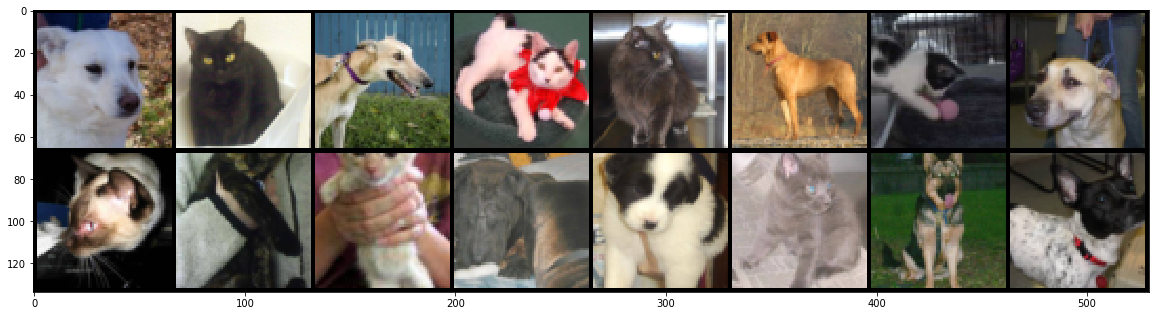

In [48]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(20,150))
    plt.imshow(inp)

inputs, classes = next(iter(test_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs, scale_each= True)

imshow(out)
# plt.savefig('example.png', dpi=300)

/home/hezhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


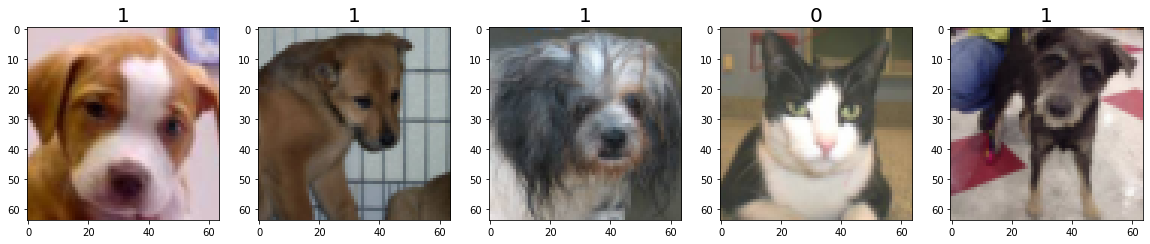

In [58]:
weight_path = 'output/resnet_oversampling.pkl'
model = ResNet34(2).to(device)
model.load_state_dict(torch.load(weight_path))
with torch.no_grad():
    for idx, (inputs,labels) in tqdm(enumerate(test_loader),total=len(test_loader)):
        inputs = inputs.to(device)
#         labels = labels.to(device)
        model.eval()
        outputs = model(inputs.float())
        pred_classes = outputs.argmax(1).cpu()
#         out = torchvision.utils.make_grid(inputs, scale_each= True)
#         imshow(out,True)
        figs, ax = plt.subplots(1,5,figsize=(20,50))
        for i in range(5):
            j = i//5
            k = i%5
            inp = inputs[i].cpu().numpy().transpose((1, 2, 0))
            ax[k].imshow(inp)
            ax[k].set_title(f'{pred_classes[i]}',fontsize=20)
            plt.savefig('result_1.png', dpi=300)
#         plt.show()
        break

In [51]:
inputs.size()

torch.Size([16, 3, 64, 64])

In [42]:
from torchsummary import summary
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 15, 15]               0
            Conv2d-5           [-1, 64, 15, 15]          36,864
       BatchNorm2d-6           [-1, 64, 15, 15]             128
              ReLU-7           [-1, 64, 15, 15]               0
            Conv2d-8           [-1, 64, 15, 15]          36,864
       BatchNorm2d-9           [-1, 64, 15, 15]             128
    ResidualBlock-10           [-1, 64, 15, 15]               0
           Conv2d-11           [-1, 64, 15, 15]          36,864
      BatchNorm2d-12           [-1, 64, 15, 15]             128
             ReLU-13           [-1, 64, 15, 15]               0
           Conv2d-14           [-1, 64,